### Description:
Here we try 5 different configurations of the XGBClassifer algorithm to find the model with the highest accuracy for predicting the `Landing_Runway` in LHR Airport.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
from cmplotter import plot_confusion_matrix
%matplotlib inline
import numpy as np
#Set some numpy print options for displaying numpy arrays to fit maximum width of cell
np.set_printoptions(precision=8, edgeitems=30, linewidth=1000,formatter=dict(float=lambda x: "%.8g" % x))

import pandas as pd
from xgboost import XGBClassifier,plot_tree
from sklearn import datasets
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder,label_binarize

In [3]:
#load Dataset
data = pd.read_csv('data/2016_EGLL_Testdata_cleaned.csv', parse_dates = ['Landing_Time'], infer_datetime_format = True)
data.head()

,Landing_Time,hourofday,aircraft_registration,wind_direction_degrees,Wind_Speed_kt,Wind_And_Gust_kt,Landing_RVR_or_Vis_m,temperature_c,dew_point_c,relative_humidity,pressure_altimiter_in,RunwayTrueTrack,Landing_Visibilty_Class_RVR,present_weather_codes,Landing_RWY
0,2016-01-01 04:34:38,4,GXLEJ,NaN,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,VMC,NaN,RW09R
1,2016-01-01 04:38:22,4,GSTBH,NaN,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,VMC,NaN,RW09R
2,2016-01-01 04:40:38,4,GCIVH,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,VMC,NaN,RW09R
3,2016-01-01 04:42:36,4,GVYUM,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,VMC,NaN,RW09R
4,2016-01-01 04:44:43,4,GBYGB,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,VMC,NaN,RW09R


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220940 entries, 0 to 220939
Data columns (total 15 columns):
Landing_Time                   220940 non-null datetime64[ns]
hourofday                      220940 non-null int64
aircraft_registration          220799 non-null object
wind_direction_degrees         203226 non-null float64
Wind_Speed_kt                  220940 non-null float64
Wind_And_Gust_kt               220940 non-null float64
Landing_RVR_or_Vis_m           220940 non-null float64
temperature_c                  220940 non-null float64
dew_point_c                    220940 non-null float64
relative_humidity              220940 non-null float64
pressure_altimiter_in          220940 non-null float64
RunwayTrueTrack                220940 non-null float64
Landing_Visibilty_Class_RVR    220940 non-null object
present_weather_codes          33015 non-null object
Landing_RWY                    220940 non-null object
dtypes: datetime64[ns](1), float64(9), int64(1), object(4)
memor

In [5]:
data['present_weather_codes']=data['present_weather_codes'].astype('str') #Convert to string to avoid TypeError when using np.unique function

# Number of unique values in Landing Visibility Class and Weather Conditions
print('No. of Unique Landing Visibility codes:',data['Landing_Visibilty_Class_RVR'].nunique(),'\n',np.unique(data['Landing_Visibilty_Class_RVR']))
print('\n No. of Unique Preset Weather Codes:',data['present_weather_codes'].nunique(),'\n',np.unique(data['present_weather_codes']))

No. of Unique Landing Visibility codes: 5 
 ['CAT1' 'CAT2' 'CAT3' 'Marginal VMC' 'VMC']

 No. of Unique Preset Weather Codes: 50 
 ['+RA' '+RA VCTS' '+SHRA' '-DZ' '-DZ BR' '-DZ FG' '-RA' '-RA VCTS' '-RADZ' '-RADZ BR' '-RADZ FG' '-RADZ HZ' '-SHRA' '-SHRA TS' '-SHRA VCTS' '-SHRASN' '-SN' '-TSRA' '//////' 'BCFG' 'BR' 'BR BCFG' 'BR MIFG' 'BR PRFG' 'BR VCFG' 'BR VCTS' 'DZ' 'FG' 'FZFG' 'HZ' 'MIFG' 'MIFG BR' 'PRFG' 'PRFG VCFG' 'RA' 'RA HZ' 'RADZ' 'RADZ FG' 'SG' 'SHRA' 'SHRA HZ' 'SHRA VCTS' 'TS' 'TSRA' 'VCFG' 'VCSH' 'VCTS' 'VCTS -SHRA' 'VCTS VCSH' 'nan']


In [6]:
# One-Hot Encoding Categorical Variables pertaining to Visibility and Weather conditions which are interesting features
data = pd.get_dummies(data, columns=['Landing_Visibilty_Class_RVR', 'present_weather_codes'])
# Dropping Categorical variables which are not going to be used by the GBM model
data.drop(columns=['Landing_Time', 'aircraft_registration'],inplace = True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220940 entries, 0 to 220939
Data columns (total 66 columns):
hourofday                                   220940 non-null int64
wind_direction_degrees                      203226 non-null float64
Wind_Speed_kt                               220940 non-null float64
Wind_And_Gust_kt                            220940 non-null float64
Landing_RVR_or_Vis_m                        220940 non-null float64
temperature_c                               220940 non-null float64
dew_point_c                                 220940 non-null float64
relative_humidity                           220940 non-null float64
pressure_altimiter_in                       220940 non-null float64
RunwayTrueTrack                             220940 non-null float64
Landing_RWY                                 220940 non-null object
Landing_Visibilty_Class_RVR_CAT1            220940 non-null uint8
Landing_Visibilty_Class_RVR_CAT2            220940 non-null uint8
Landing_Visi

In [8]:
input_features = data.copy()
X_data = input_features.drop('Landing_RWY', axis=1)
y = data.Landing_RWY.values

In [9]:
X_data.head()

,hourofday,wind_direction_degrees,Wind_Speed_kt,Wind_And_Gust_kt,Landing_RVR_or_Vis_m,temperature_c,dew_point_c,relative_humidity,pressure_altimiter_in,RunwayTrueTrack,...,present_weather_codes_SHRA HZ,present_weather_codes_SHRA VCTS,present_weather_codes_TS,present_weather_codes_TSRA,present_weather_codes_VCFG,present_weather_codes_VCSH,present_weather_codes_VCTS,present_weather_codes_VCTS -SHRA,present_weather_codes_VCTS VCSH,present_weather_codes_nan
0,4,NaN,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,...,0,0,0,0,0,0,0,0,0,1
1,4,NaN,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,...,0,0,0,0,0,0,0,0,0,1
2,4,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,...,0,0,0,0,0,0,0,0,0,1
3,4,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,...,0,0,0,0,0,0,0,0,0,1
4,4,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,...,0,0,0,0,0,0,0,0,0,1


In [10]:
# Number of unique values Ytrn
n_classes = len(np.unique(y))
print('No. of Classes in the output:',n_classes,'and the classes are:',np.unique(y))

No. of Classes in the output: 4 and the classes are: ['RW09L' 'RW09R' 'RW27L' 'RW27R']


In [11]:
## One Hot Encode categorical variable output converting the class labels to integers
encoder = LabelEncoder()
encoded_y = encoder.fit_transform(y)
print('Encoded-Y:',encoded_y)

Encoded-Y: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ... 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [12]:
## Convert class labels to binary representation for each of the four classes such as [0 1 0 0], [1 0 0 0], [0 0 1 0] and [0 0 0 1]
# y_bin_enc = label_binarize(y, classes=['RW09L','RW09R','RW27L','RW27R'])
# print('Output-Y:',y_bin_enc)

In [13]:
#Split the dataset into train and Test
seed = 42
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=test_size, random_state=seed)

In [14]:
# Sanity Check
print("Train dataset contains {0} rows and {1} columns".format(X_train.shape[0], X_train.shape[1]))
print("Test dataset contains {0} rows and {1} columns".format(X_test.shape[0], X_test.shape[1]))

Train dataset contains 154658 rows and 65 columns
Test dataset contains 66282 rows and 65 columns


In [15]:
print("Train possible labels: ")
print(np.unique(y_train))

print("\nTest possible labels: ")
print(np.unique(y_test))

Train possible labels: 
['RW09L' 'RW09R' 'RW27L' 'RW27R']

Test possible labels: 
['RW09L' 'RW09R' 'RW27L' 'RW27R']


In [16]:
def correct_predictions_counter(y_test,y_pred):
    '''Takes in the predictions of a model output and returns the no. of correct predictions.
    Arguments: y_test, y_pred'''
    correct = 0
    for i in range(len(y_pred)):
        if (y_test[i] == y_pred[i]):
            correct += 1
    return correct

## Training Classifier

### Model 1:
 Base model without any parameters.

In [17]:
%%time
# Train the XGboost Model for Classification
model1 = XGBClassifier().fit(X_train, y_train)

# Make a Prediction with Model1
pred1 = model1.predict(X_test)
pred1

Wall time: 2min 9s


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


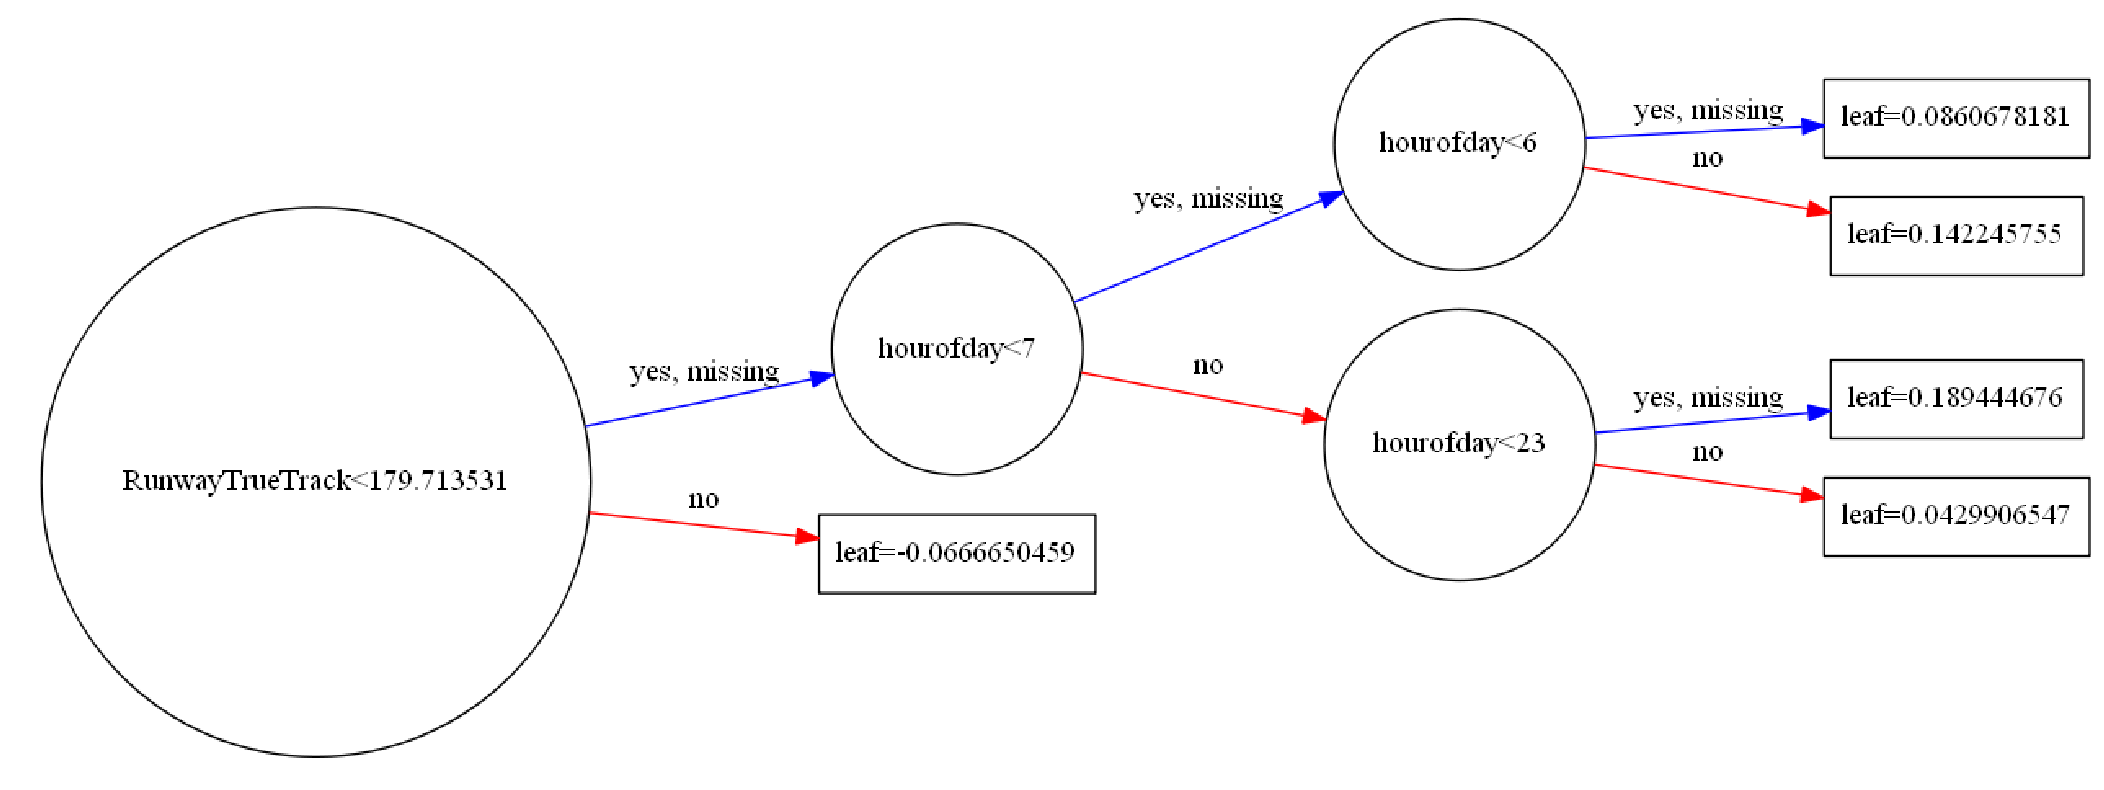

In [18]:
# plot single tree segment to illustrate decision tree concept
plot_tree(model1,rankdir='LR',num_trees=0)
fig = plt.gcf()
fig.set_size_inches(37,25)

In [19]:
# Calculate Obtained Error
print('Predicted correctly: {0}/{1}'.format(correct_predictions_counter(y_test,pred1), len(pred1)))
print('Model 1 XGboost Report:','\n', (classification_report(y_test, pred1)),'\n')
print("Accuracy for model 1: %.2f" % (accuracy_score(y_test, pred1) * 100))

Predicted correctly: 46320/66282
Model 1 XGboost Report: 
              precision    recall  f1-score   support

      RW09L       0.93      1.00      0.96     17892
      RW09R       0.58      0.06      0.11      1449
      RW27L       0.61      0.59      0.60     23563
      RW27R       0.60      0.62      0.61     23378

avg / total       0.69      0.70      0.69     66282
 

Accuracy for model 1: 69.88


### Model 2:
- we are dealing with multilabel classification problem (`'objective':'multi:softmax'`),
- we want shallow single trees with no more than 4 levels (`'max_depth':4`),
- we want no output (so set `'silent':1`)
- we want algorithm to learn moderately fast (`'learning_rate':0.2`), (in naive named `eta`)
- we want to iterate only 100 rounds (`n_estimators`)

In [20]:
params = {
    'objective': 'multi:softmax',
    'silent': 1,
    'max_depth': 4,
    'learning_rate': 0.2,    
    'n_estimators': 100
}

In [21]:
%%time
# Train the XGboost Model for Classification
model2 = XGBClassifier(**params).fit(X_train, y_train)
# Make a Prediction with Model2
pred2 = model2.predict(X_test)

Wall time: 2min 26s


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [22]:
## Plot single tree
# plot_tree(model2,rankdir='LR',num_trees=4)
# fig = plt.gcf()
# fig.set_size_inches(37,25)

In [23]:
print('Model 2 XGboost Report:','\n', (classification_report(y_test, pred2)),'\n')
# Calculate Obtained Error
print('Predicted correctly: {0}/{1}'.format(correct_predictions_counter(y_test,pred2), len(pred2)))
print("Accuracy for model 3: %.2f" % (accuracy_score(y_test, pred2) * 100),'%')
print('Error: {0:.4f}'.format(1-(accuracy_score(y_test, pred2))))

Model 2 XGboost Report: 
              precision    recall  f1-score   support

      RW09L       0.93      1.00      0.96     17892
      RW09R       0.69      0.12      0.20      1449
      RW27L       0.73      0.73      0.73     23563
      RW27R       0.73      0.72      0.72     23378

avg / total       0.78      0.79      0.78     66282
 

Predicted correctly: 52080/66282
Accuracy for model 3: 78.57 %
Error: 0.2143


In [24]:
print(confusion_matrix(y_test, pred2))

[[17818    74     0     0]
 [ 1282   167     0     0]
 [    0     0 17198  6365]
 [    0     0  6481 16897]]


### Model 3:
All the parameters are set like in the previous example
- we want deep single trees with no more than 8 levels (`'max_depth':8`),
- we want algorithm to learn slow and steadily (`'learning_rate':0.1`)
- we don't any oupout (`'silent':1`)
- we want to iterate 100 rounds (`n_estimators`)
- In every boosting iteration, randomly sample half of the training data prior to growing trees to prevent over-fitting (`'subsample':0.5`)

In [25]:
params = {
    'objective': 'multi:softmax',
    'silent': 1,
    'max_depth': 8,
    'learning_rate': 0.1,    
    'n_estimators': 100,
    'subsample': 0.5
}

In [26]:
%%time
model3 = XGBClassifier(**params).fit(X_train, y_train)
pred3 = model3.predict(X_test)

Wall time: 4min 40s


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [27]:
# Calculate Obtained Error      
acc = accuracy_score(y_test, pred3)
print('Model 3 XGboost Report:','\n', (classification_report(y_test, pred3)),'\n')
print('Predicted correctly: {0}/{1}'.format(correct_predictions_counter(y_test,pred3), len(pred3)))
print("Accuracy for model 2: {0:.2f} %".format(acc * 100)) 
print('Error: {0:.4f}'.format(1-acc))

Model 3 XGboost Report: 
              precision    recall  f1-score   support

      RW09L       0.94      0.99      0.96     17892
      RW09R       0.64      0.22      0.33      1449
      RW27L       0.88      0.87      0.87     23563
      RW27R       0.87      0.88      0.87     23378

avg / total       0.89      0.89      0.89     66282
 

Predicted correctly: 59030/66282
Accuracy for model 2: 89.06 %
Error: 0.1094


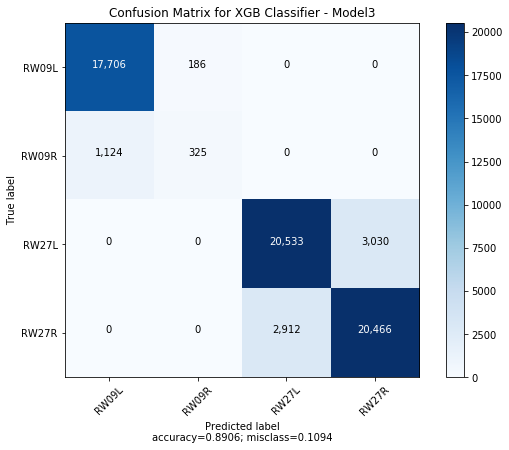

In [28]:
# Plot Confusion Matrix of classification Results
plot_confusion_matrix(cm= confusion_matrix(y_test, pred3), 
                      normalize    = False,
                      target_names = np.unique(y_test),
                      title        = "Confusion Matrix for XGB Classifier - Model3")

### Model 4:
This model configuration has been implemented after the results of the random search.
- we want deep single trees with no more than 12 levels (`'max_depth':12`),
- we want algorithm to learn slow and steadily (`'learning_rate':0.01`)
- we want to iterate 1000 rounds (`n_estimators`)
- In every boosting iteration, randomly sample the training data prior to growing trees to prevent over-fitting (`'subsample':0.8`)
- For understanding the sinificance of more parameters. __Refer__:https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [29]:
params = {
    'objective': 'multi:softmax',
    'silent': 1,
    'max_depth': 12,
    'learning_rate': 0.01,
    'subsample': 0.8,    
    'n_estimators': 1000,    
    'min_child_weight': 6,
    'gamma':0,    
    'colsample_bytree':0.8,
    'reg_alpha':0.005,    
    'n_jobs':4,
    'scale_pos_weight':1,
    'random_state':42
}

In [30]:
%%time
model4 = XGBClassifier(**params).fit(X_train, y_train)
pred4 = model4.predict(X_test)

Wall time: 28min 20s


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [31]:
# Calculate Obtained Error      
acc = accuracy_score(y_test, pred4)
print('Model 4 XGboost Report:','\n', (classification_report(y_test, pred4)),'\n')
print('Predicted correctly: {0}/{1}'.format(correct_predictions_counter(y_test,pred4), len(pred4)))
print("Accuracy for model 4: {0:.2f} %".format(acc * 100)) 
print('Error: {0:.4f}'.format(1-acc))

Model 4 XGboost Report: 
              precision    recall  f1-score   support

      RW09L       0.94      0.99      0.96     17892
      RW09R       0.62      0.23      0.34      1449
      RW27L       0.94      0.94      0.94     23563
      RW27R       0.94      0.94      0.94     23378

avg / total       0.93      0.94      0.93     66282
 

Predicted correctly: 62183/66282
Accuracy for model 4: 93.82 %
Error: 0.0618


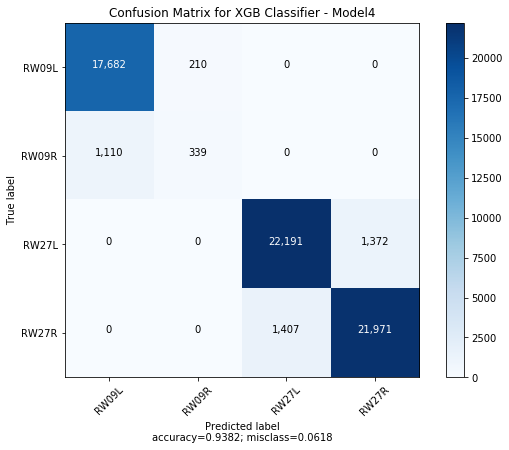

In [32]:
# Plot Confusion Matrix of classification Results
plot_confusion_matrix(cm= confusion_matrix(y_test, pred4), 
                      normalize    = False,
                      target_names = np.unique(y_test),
                      title        = "Confusion Matrix for XGB Classifier - Model4")

### Model 5:
This model configuration has been implemented after the results of the grid search.
- we want deep single trees with no more than 16 levels (`'max_depth':16`),
- we want algorithm to learn slow and steadily (`'learning_rate':0.0075`)
- we want to iterate 1000 rounds ( `'n_estimators'` :1000)
- In every boosting iteration, randomly sample half of the training data prior to growing trees to prevent over-fitting (`'subsample':0.5`)
- For understanding the sinificance of more parameters. __Refer__:https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [33]:
params = {
    'objective': 'multi:softmax',
    'silent': 1,
    'max_depth': 16,
    'learning_rate': 0.0075,    
    'n_estimators': 1000,
    'subsample': 0.5,
    'min_child_weight': 6,
    'gamma':0,    
    'colsample_bytree':0.8,
    'reg_alpha':0.005,    
    'n_jobs':4,
    'scale_pos_weight':1,
    'random_state':42
}

In [34]:
%%time
model5 = XGBClassifier(**params).fit(X_train, y_train)
pred5 = model5.predict(X_test)

Wall time: 34min 38s


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [35]:
# Calculate Obtained Error      
acc = accuracy_score(y_test, pred5)
print('Model 5 XGboost Report:','\n', (classification_report(y_test, pred5)),'\n')
print('Predicted correctly: {0}/{1}'.format(correct_predictions_counter(y_test,pred5), len(pred5)))
print("Accuracy for model 5: {0:.2f} %".format(acc * 100)) 
print('Error: {0:.4f}'.format(1-acc))

Model 5 XGboost Report: 
              precision    recall  f1-score   support

      RW09L       0.94      0.99      0.96     17892
      RW09R       0.62      0.23      0.34      1449
      RW27L       0.94      0.94      0.94     23563
      RW27R       0.94      0.94      0.94     23378

avg / total       0.94      0.94      0.94     66282
 

Predicted correctly: 62331/66282
Accuracy for model 5: 94.04 %
Error: 0.0596


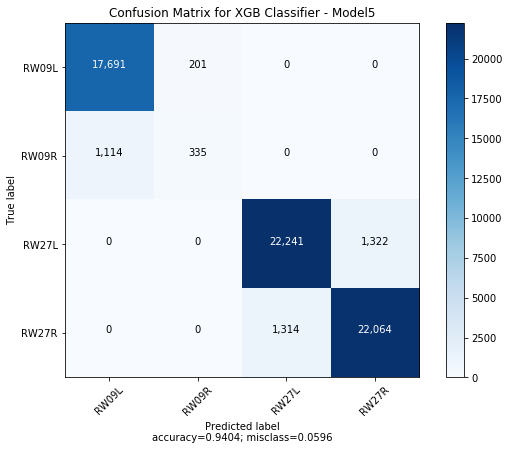

In [36]:
# Plot Confusion Matrix of classification Results
plot_confusion_matrix(cm= confusion_matrix(y_test, pred5), 
                      normalize    = False,
                      target_names = np.unique(y_test),
                      title        = "Confusion Matrix for XGB Classifier - Model5")

### Notes:
- Metric `roc_auc_score` is __not applicable__ for multi-class classification problem. It is applicable only for binary classification problems.

### Resources:
- [Plotting Trees in XGBoost](https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/)
- [SciKit Learn - Plot Confusion Matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
- [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)